## Homework 1

In [46]:
#setup the enviroment
import zipfile
import glob
import pandas as pd

### Step 1

In [47]:
zipper = zipfile.ZipFile('data/wweCalls.zip')
zipper.extractall('data')

In [48]:
wwe_file_names = glob.glob('data/wwe_parsed*')#we only need file that start with ww_parsed

In [52]:
df_wwe = pd.DataFrame()
for i, file in enumerate(wwe_file_names):
    df_wwe_single = pd.read_csv(file)
    df_wwe = df_wwe.append(df_wwe_single)

df_wwe['date'] = pd.to_datetime(df_wwe['date']).dt.date

In [44]:
len(df_wwe) #good to go

2239

### Step 2

In [6]:
import requests
import datetime

In [7]:
def get_url(ticker, api, csv): #we are using API forget about the csv!
    if csv == True:
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize=full&apikey={}&datatype=csv'.format(ticker, api)
    else: 
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize=full&apikey={}'.format(ticker, api)
    return url

#I need to change the outputsize to full, they intraday search will shows other date's data, and the time_series_daily don't support date search

In [58]:
#creating a function that will make our date pulling process more flexible
def pull_dates(target_date, up_range, down_range):
    start_date = pd.to_datetime(target_date).date() - datetime.timedelta(days = down_range)
    end_date = pd.to_datetime(target_date).date() + datetime.timedelta(days = up_range)
    
    dates = pd.date_range(start_date, end_date, freq= 'd').date
    return dates

In [59]:
#combining previous function together
def get_stock_stats(date_list, ticker, api, csv, up_range, down_range):

    dates = []
    for target_date in date_list:
        dates_temp = pull_dates(target_date= target_date, up_range= up_range, down_range= down_range)
        dates.extend(dates_temp)
    
    dates = pd.unique(dates)


    url = get_url(ticker, api, csv )
    
    records = []
    market_close_dates = [] 

    if csv == True: #for csv
        results = pd.read_csv(url) #like AWS S3, using pd.read_csv can call the file
        results['timestamp'] = pd.to_datetime(results['timestamp']).dt.date 

        records = results[results.timestamp.isin(dates)]
        date_temp = dates[pd.Series(dates).isin(records.timestamp) == False]
        records = records.reset_index(drop= True)
        records.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

        for date in date_temp:
            market_close_dates.append(str(date))
    
    else: #for json file
        results = requests.get(url).json()['Time Series (Daily)'] #call the file from json

        for date in dates:
            try:
                date = str(date)
                result = results[date]
                open = result['1. open']
                high = result['2. high']
                low = result['3. low']
                close = result['4. close']
                volume = result['5. volume']

                record = (date, open, high, low, close, volume)
                records.append(record)
            
            except:
                market_close_dates.append(date)

    return(records, market_close_dates)



In [61]:
date_list = pd.unique(df_wwe.date)
ticker = 'WWE' 
API_key = 'M543IPRN9W3SOBPZ'


records,close_dates =  get_stock_stats(date_list = date_list, 
                        ticker = ticker, 
                        api= API_key, 
                        csv= True, #csv form will return dataframe, json form will be np.array
                        up_range= 5, 
                        down_range= 5)

#the result will return the valid record, and the date that market is close

In [64]:
display(records, 'Market was closing on these dates:',close_dates) #we decide to call the csv file here, the result is faster than json.

,date,open,high,low,close,volume
0,2010-12-03,13.93,14.04,13.90,14.00,350400
1,2010-12-02,13.95,14.05,13.93,14.00,236200
2,2010-12-01,14.18,14.18,13.88,13.93,296800
3,2010-11-30,13.90,14.09,13.90,14.02,230300
4,2010-11-29,14.02,14.14,13.88,14.02,200400
...,...,...,...,...,...,...
220,2002-06-27,14.30,14.45,13.15,13.55,82200
221,2002-06-26,13.50,14.60,13.50,14.20,106100
222,2002-06-25,13.60,13.81,13.55,13.69,39600
223,2002-06-24,13.60,13.65,13.20,13.55,52100


'Market was closing on these dates:'

['2010-02-06',
 '2010-02-07',
 '2010-02-13',
 '2010-02-14',
 '2010-02-15',
 '2008-02-09',
 '2008-02-10',
 '2008-02-16',
 '2008-02-17',
 '2007-02-10',
 '2007-02-11',
 '2007-02-17',
 '2007-02-18',
 '2006-06-10',
 '2006-06-11',
 '2006-06-17',
 '2006-06-18',
 '2003-11-15',
 '2003-11-16',
 '2003-11-22',
 '2004-02-14',
 '2004-02-15',
 '2004-02-16',
 '2004-02-21',
 '2004-02-22',
 '2009-03-14',
 '2009-03-15',
 '2009-03-21',
 '2009-03-22',
 '2005-11-26',
 '2005-11-27',
 '2005-12-03',
 '2005-12-04',
 '2007-10-27',
 '2007-10-28',
 '2007-11-03',
 '2007-11-04',
 '2004-06-19',
 '2004-06-20',
 '2004-06-26',
 '2004-06-27',
 '2004-08-21',
 '2004-08-22',
 '2004-08-28',
 '2005-02-19',
 '2005-02-20',
 '2005-02-21',
 '2005-02-26',
 '2005-02-27',
 '2004-11-20',
 '2004-11-21',
 '2004-11-25',
 '2004-11-27',
 '2004-11-28',
 '2009-02-21',
 '2009-02-22',
 '2009-02-28',
 '2009-03-01',
 '2003-08-23',
 '2003-08-24',
 '2003-08-30',
 '2003-08-31',
 '2002-06-22',
 '2002-06-23',
 '2002-06-29',
 '2002-06-30',
 '2007-07-

### Step 3

In [460]:
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure

In [381]:
def page_result(page):
    url = 'https://www.wrestlingdata.com/index.php?befehl=quoten&art=3&liga=1&show=&sort=1&seite={}'.format(page)
    result_raw = requests.get(url).text
    results = BeautifulSoup(result_raw)
    result_parent = results.find_all('table',{'style':'width:98%;', 'cellpadding' : '4', 'cellspacing': '2'})[1]#find the physical location of the table
    result = result_parent.find_all('tr') #each 'tr' means one row of data
    page_stats = []

    for stats in result: 
            try: 
                stats_parent = stats.find_all('td')
                date = pd.to_datetime(stats_parent[0].text)
                event = stats_parent[1].text
                buyrate_relative = float(stats_parent[2].text)
                buyrate_absolute_raw = stats_parent[3].text
                if buyrate_absolute_raw == '-':
                    buyrate_absolute = np.nan
                else: 
                    buyrate_absolute = int(buyrate_absolute_raw.replace(',', '')) 

                row = (date, event, buyrate_relative, buyrate_absolute)
                page_stats.append(row)
            except: 
                continue
    return(page_stats)



In [448]:
def all_page_stats(n_page): 
    all_stats = pd.DataFrame()

    for page in range(1,n_page+1): #there is no page 0
        page_stats = page_result(page)
        page_stats = pd.DataFrame(page_stats)

        all_stats = pd.concat([all_stats, page_stats], ignore_index= True)
    
    all_stats.columns = ['date', 'event', 'buyrate_relative', 'buyrate_absolute'] # the result will be a dataframe

    return(all_stats)


In [457]:
total_data = all_page_stats(6)
total_data.head()

,date,event,buyrate_relative,buyrate_absolute
0,1987-03-29,WWF WrestleMania III,10.20,4080000.0
1,1987-11-26,WWF Survivor Series 1987,7.00,2800000.0
2,1988-03-27,WWF WrestleMania IV,6.50,2600000.0
3,1989-04-02,WWF WrestleMania V,5.90,2360000.0
4,1989-08-28,WWF SummerSlam 1989,4.81,1924000.0


<AxesSubplot:xlabel='date', ylabel='buyrate_absolute'>

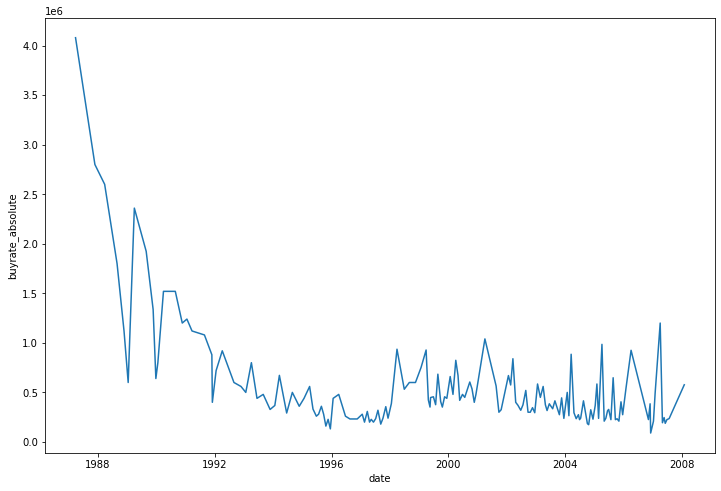

In [463]:
figure(figsize=(12, 8))
sns.lineplot(data= total_data, x = 'date', y= 'buyrate_absolute')
#it seems like the absolute buyrate drop ever since 80s and remain a in range after 1998